# Part I - Exploratory Analysis of U.S. Airline Flight Delays
## by Tyler Wilcoxson

## Introduction

This dataset contains information on approximately 2 million U.S. domestic flights from the Bureau of Transportation Statistics' "Reporting Carrier On-Time Performance" database. Each record represents a single flight and includes details about the carrier, origin and destination airports, scheduled and actual departure/arrival times, delay durations, and the causes of delays (carrier, weather, NAS, security, and late aircraft).

**Questions to investigate:**

1. What does the overall distribution of flight delays look like? Are most flights on time?
2. Which airlines have the most flights, and which experience the worst delays?
3. How do delays vary by time of day, day of week, and month of year?
4. What is the relationship between departure delay and arrival delay -- can airlines make up lost time?
5. What are the primary causes of delays, and how do they interact with each other?

## Preliminary Wrangling

In [1]:
# Import packages and configure inline plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Set consistent plot style
sns.set_style('whitegrid')
plt.rcParams.update({
    'figure.figsize': (10, 6),
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 100
})

In [2]:
# Define columns of interest to reduce memory usage
use_cols = [
    'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'FlightDate',
    'Reporting_Airline', 'Origin', 'OriginCityName', 'OriginState',
    'Dest', 'DestCityName', 'DestState',
    'CRSDepTime', 'DepDelay', 'DepDelayMinutes', 'DepDel15',
    'DepTimeBlk', 'TaxiOut', 'TaxiIn',
    'CRSArrTime', 'ArrDelay', 'ArrDelayMinutes', 'ArrDel15',
    'Cancelled', 'Diverted',
    'CRSElapsedTime', 'ActualElapsedTime', 'AirTime',
    'Distance', 'DistanceGroup',
    'CarrierDelay', 'WeatherDelay', 'NASDelay',
    'SecurityDelay', 'LateAircraftDelay'
]

# Load dataset with selected columns (latin-1 encoding for special characters)
df = pd.read_csv('data/airline_2m.csv', usecols=use_cols, encoding='latin-1')
print(f'Dataset shape: {df.shape}')
print(f'Memory usage: {df.memory_usage(deep=True).sum() / 1e6:.1f} MB')

Dataset shape: (2000000, 35)


Memory usage: 1412.6 MB


In [3]:
# Inspect data types and first few rows
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
FlightDate            object
Reporting_Airline     object
Origin                object
OriginCityName        object
OriginState           object
Dest                  object
DestCityName          object
DestState             object
CRSDepTime             int64
DepDelay             float64
DepDelayMinutes      float64
DepDel15             float64
DepTimeBlk            object
TaxiOut              float64
TaxiIn               float64
CRSArrTime             int64
ArrDelay             float64
ArrDelayMinutes      float64
ArrDel15             float64
Cancelled            float64
Diverted             float64
CRSElapsedTime       float64
ActualElapsedTime    float64
AirTime              float64
Distance             float64
DistanceGroup          int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDe

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,OriginCityName,OriginState,Dest,...,CRSElapsedTime,ActualElapsedTime,AirTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,1998,1,2,5,1998-01-02,NW,MSP,"Minneapolis, MN",MN,SLC,...,176.0,180.0,153.0,991.0,4,NaN,NaN,NaN,NaN,NaN
1,2009,5,28,4,2009-05-28,FL,MKE,"Milwaukee, WI",WI,MCO,...,157.0,159.0,141.0,1066.0,5,NaN,NaN,NaN,NaN,NaN
2,2013,6,29,6,2013-06-29,MQ,GJT,"Grand Junction, CO",CO,DFW,...,135.0,118.0,103.0,773.0,4,NaN,NaN,NaN,NaN,NaN
3,2010,8,31,2,2010-08-31,DL,LAX,"Los Angeles, CA",CA,DTW,...,270.0,250.0,220.0,1979.0,8,NaN,NaN,NaN,NaN,NaN
4,2006,1,15,7,2006-01-15,US,EWR,"Newark, NJ",NJ,CLT,...,126.0,107.0,80.0,529.0,3,0.0,0.0,0.0,0.0,32.0


In [5]:
# Check for missing values
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(1)
null_summary = pd.DataFrame({'Count': null_counts, 'Percent': null_pct})
null_summary[null_summary['Count'] > 0]

,Count,Percent
OriginState,646,0.0
DestState,594,0.0
DepDelay,36068,1.8
DepDelayMinutes,36068,1.8
DepDel15,36068,1.8
TaxiOut,415642,20.8
TaxiIn,417847,20.9
ArrDelay,41078,2.1
ArrDelayMinutes,41078,2.1
ArrDel15,41078,2.1


In [6]:
# Summary statistics for key numeric columns
df[['DepDelay', 'ArrDelay', 'Distance', 'AirTime', 'TaxiOut', 'TaxiIn']].describe()

,DepDelay,ArrDelay,Distance,AirTime,TaxiOut,TaxiIn
count,1.963932e+06,1.958922e+06,2.000000e+06,1.580651e+06,1.584358e+06,1.582153e+06
mean,8.587405e+00,6.205467e+00,7.334963e+02,1.059533e+02,1.580659e+01,6.714089e+00
std,3.272473e+01,3.483340e+01,5.684968e+02,6.859287e+01,1.023564e+01,7.948352e+00
min,-9.900000e+02,-7.060000e+02,1.100000e+01,-7.030000e+02,0.000000e+00,0.000000e+00
25%,-3.000000e+00,-1.000000e+01,3.250000e+02,5.600000e+01,1.000000e+01,4.000000e+00
50%,0.000000e+00,-1.000000e+00,5.800000e+02,8.700000e+01,1.300000e+01,5.000000e+00
75%,7.000000e+00,1.000000e+01,9.670000e+02,1.350000e+02,1.800000e+01,8.000000e+00
max,1.878000e+03,1.898000e+03,5.095000e+03,9.650000e+02,1.412000e+03,1.439000e+03


In [7]:
# Feature engineering

# Extract departure hour from scheduled departure time (e.g., 1640 -> 16)
df['DepHour'] = (df['CRSDepTime'] // 100).clip(0, 23).astype(int)

# Map DayOfWeek to day names as ordered categorical
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['DayName'] = pd.Categorical(
    df['DayOfWeek'].map(dict(enumerate(day_labels, 1))),
    categories=day_labels, ordered=True
)

# Map Month to month names as ordered categorical
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['MonthName'] = pd.Categorical(
    df['Month'].map(dict(enumerate(month_labels, 1))),
    categories=month_labels, ordered=True
)

# Create delay severity categories for arrival delay
bins = [-np.inf, 0, 15, 60, 180, np.inf]
labels = ['On Time/Early', 'Minor (1-15)', 'Moderate (16-60)',
          'Severe (61-180)', 'Extreme (>180)']
df['DelayCategory'] = pd.Categorical(
    pd.cut(df['ArrDelay'], bins=bins, labels=labels),
    categories=labels, ordered=True
)

# Identify dominant delay cause for delayed flights
delay_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay',
              'SecurityDelay', 'LateAircraftDelay']
cause_labels = ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft']
delayed_mask = df[delay_cols].notna().all(axis=1)
df.loc[delayed_mask, 'DominantCause'] = df.loc[delayed_mask, delay_cols].idxmax(axis=1)
df['DominantCause'] = df['DominantCause'].map(dict(zip(delay_cols, cause_labels)))

print('Feature engineering complete.')
print(f'Flights with delay cause data: {delayed_mask.sum():,}')
print(f'Cancelled flights: {df["Cancelled"].sum():,.0f}')
print(f'Airlines in dataset: {df["Reporting_Airline"].nunique()}')
print(f'Origin airports: {df["Origin"].nunique()}')
print(f'Year range: {df["Year"].min()} - {df["Year"].max()}')

Feature engineering complete.
Flights with delay cause data: 221,803
Cancelled flights: 36,462
Airlines in dataset: 33
Origin airports: 406
Year range: 1987 - 2020


### What is the structure of your dataset?

The dataset contains approximately 2 million flight records with 109 original columns, of which we selected 31 for analysis. Each row represents a single domestic U.S. flight. Key variable types include:
- **Temporal:** Year, Month, DayOfWeek, FlightDate, scheduled departure/arrival times
- **Categorical:** Reporting airline, origin/destination airports and cities
- **Numeric (continuous):** Departure delay, arrival delay, distance, air time, taxi times
- **Numeric (delay causes):** Carrier, weather, NAS, security, and late aircraft delay minutes (only populated for flights delayed 15+ minutes)
- **Binary:** Cancelled, Diverted

### What is/are the main feature(s) of interest in your dataset?

The primary feature of interest is **arrival delay** (`ArrDelay`), measured in minutes. A negative value means the flight arrived early, zero means on time, and positive means delayed. The BTS considers a flight "delayed" when `ArrDelay >= 15` minutes.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

- **Temporal features:** Month, DayOfWeek, and departure hour to identify when delays occur
- **Airline:** `Reporting_Airline` to compare carrier performance
- **Departure delay:** To examine the cascade from departure to arrival
- **Delay causes:** The five delay cause columns to understand root causes
- **Distance:** To examine whether route length affects delay patterns

## Univariate Exploration

In [8]:
# Helper function for consistent plot formatting

def plot_hist(data, column, bins=30, title='', xlabel='', ylabel='Count',
              clip_range=None, figsize=(10, 6), vlines=None):
    """Create a styled histogram with optional reference lines and range filtering."""
    fig, ax = plt.subplots(figsize=figsize)
    plot_data = data[column].dropna()
    if clip_range:
        # Filter (not clip) to avoid artificial pile-up at boundaries
        plot_data = plot_data[(plot_data >= clip_range[0]) & (plot_data <= clip_range[1])]
    ax.hist(plot_data, bins=bins, edgecolor='white', color='steelblue', alpha=0.8)
    if vlines:
        for val, label, color in vlines:
            ax.axvline(val, color=color, linestyle='--', linewidth=1.5, label=label)
        ax.legend()
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def plot_count(data, column, title='', xlabel='', ylabel='',
               figsize=(10, 6), order=None, orient='v', palette='viridis',
               show_values=True):
    """Create a styled count plot with optional value labels."""
    fig, ax = plt.subplots(figsize=figsize)
    if orient == 'h':
        sns.countplot(y=column, data=data, order=order, hue=column,
                      palette=palette, legend=False, ax=ax)
        if show_values:
            counts = data[column].value_counts()
            for i, idx in enumerate(order if order is not None else counts.index):
                ax.text(counts[idx] + counts.max() * 0.01, i,
                        f'{counts[idx]:,}', va='center', fontsize=9)
    else:
        sns.countplot(x=column, data=data, order=order, hue=column,
                      palette=palette, legend=False, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.tight_layout()
    plt.show()


def plot_delay_rate(data, group_col, delay_col='ArrDel15', title='',
                    xlabel='', ylabel='Delay Rate (%)', figsize=(10, 6),
                    show_avg=True, show_values=True):
    """Create a bar chart of delay rates grouped by a categorical variable."""
    valid = data[data[delay_col].notna()]
    rates = valid.groupby(group_col, observed=True)[delay_col].mean() * 100

    fig, ax = plt.subplots(figsize=figsize)
    rates.plot(kind='bar', color='steelblue', edgecolor='white', ax=ax,
               label='_nolegend_')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    if show_avg:
        avg = valid[delay_col].mean() * 100
        ax.axhline(avg, color='red', linestyle='--', linewidth=1.5,
                   label=f'Overall Average ({avg:.1f}%)')
        ax.legend()

    if show_values:
        for i, val in enumerate(rates):
            ax.text(i, val + 0.3, f'{val:.1f}%', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

### Question 1: What does the distribution of arrival delays look like?

**Assumption:** We expect a right-skewed distribution with most flights arriving on time or early, since airlines build buffer time into their schedules. We also expect a long right tail of severely delayed flights.

**Approach:** A histogram is the natural choice for examining the distribution of a continuous variable. We'll clip the display range to [-60, 120] minutes to focus on the central pattern without compression from extreme outliers, and add reference lines at key thresholds (0 min = on time, 15 min = BTS "delayed" threshold).

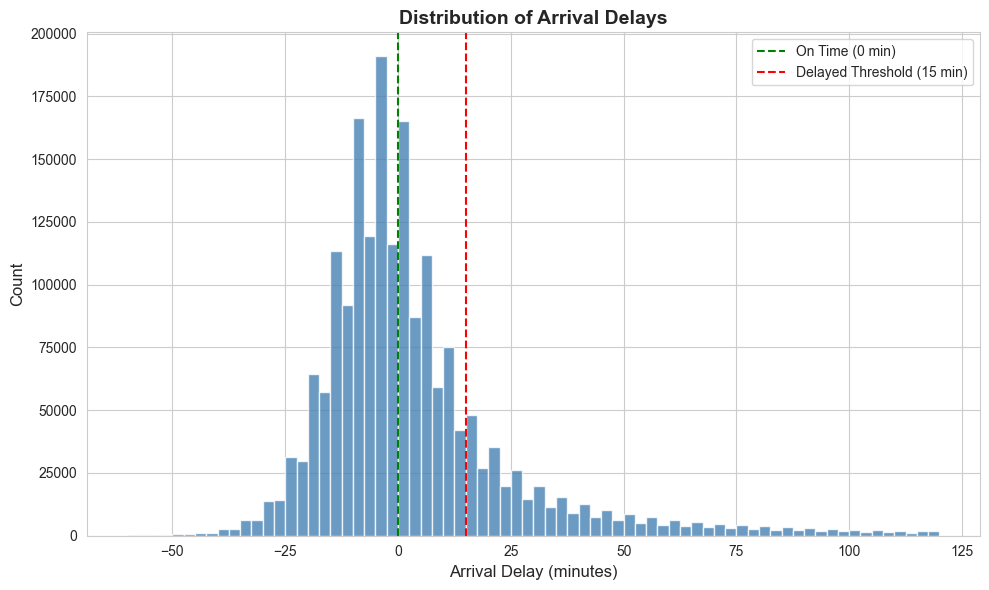

Median arrival delay: -1 minutes
Mean arrival delay: 6.2 minutes
Flights on time or early: 56.1%
Flights delayed >= 15 min: 19.8%


In [9]:
# Visualization 1: Histogram of arrival delays
plot_hist(
    df, 'ArrDelay', bins=72,
    title='Distribution of Arrival Delays',
    xlabel='Arrival Delay (minutes)',
    clip_range=(-60, 120),
    vlines=[
        (0, 'On Time (0 min)', 'green'),
        (15, 'Delayed Threshold (15 min)', 'red')
    ]
)

# Print summary statistics
arr_delay = df['ArrDelay'].dropna()
print(f'Median arrival delay: {arr_delay.median():.0f} minutes')
print(f'Mean arrival delay: {arr_delay.mean():.1f} minutes')
print(f'Flights on time or early: {(arr_delay <= 0).mean():.1%}')
print(f'Flights delayed >= 15 min: {(arr_delay >= 15).mean():.1%}')

**Observation:** The distribution is strongly right-skewed. The majority of flights arrive early or on time (peak around -5 to 0 minutes). The median is near zero, but the mean is pulled higher by a long right tail of severely delayed flights. About 80% of flights arrive within 15 minutes of schedule.

### Question 2: Which airlines operate the most flights in this dataset?

**Assumption:** We expect major legacy carriers (AA, DL, UA) and large low-cost carriers (WN/Southwest) to dominate the dataset, with regional carriers making up a smaller share. Understanding flight volume by carrier is important context before comparing delay performance.

**Approach:** A horizontal count plot is ideal here -- it shows the count distribution of a categorical variable and horizontal orientation keeps airline codes readable.

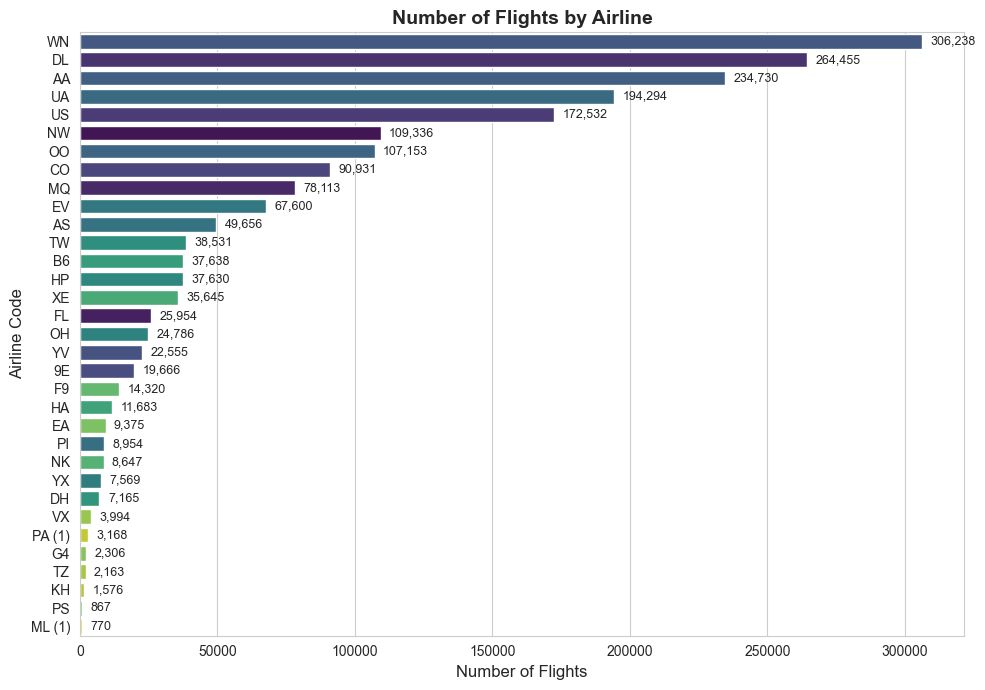

In [10]:
# Visualization 2: Count plot of flights by airline (uses plot_count helper)
airline_order = df['Reporting_Airline'].value_counts().index.tolist()

plot_count(df, 'Reporting_Airline',
           title='Number of Flights by Airline',
           xlabel='Number of Flights',
           ylabel='Airline Code',
           order=airline_order, orient='h',
           figsize=(10, 7))

**Observation:** The dataset shows a clear hierarchy of carrier sizes. Major legacy and low-cost carriers (WN/Southwest, DL/Delta, AA/American, UA/United) dominate the dataset with the highest flight volumes. Regional and smaller carriers have significantly fewer flights.

### Question 3: How does the delay rate vary by month of year?

**Assumption:** Summer months (June-August) should have higher delay rates due to thunderstorm season, and December may spike due to winter weather and holiday congestion. Fall months (September-November) should be the best.

**Approach:** A bar chart showing the percentage of flights delayed by 15+ minutes per month, with an overall average reference line, will reveal seasonal patterns clearly.

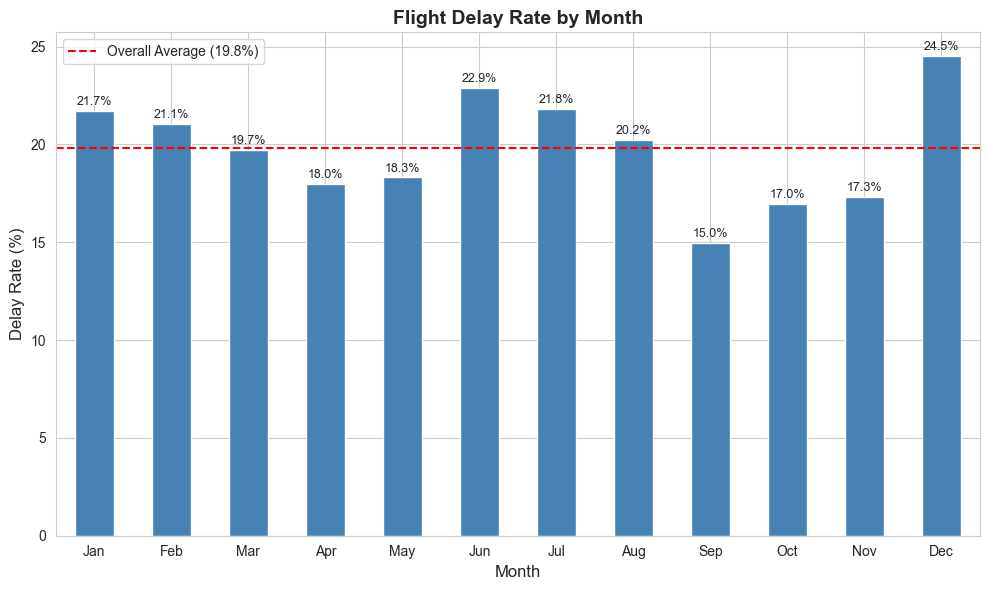

In [11]:
# Visualization 3: Delay rate by month (uses plot_delay_rate helper)
plot_delay_rate(df, 'MonthName',
                title='Flight Delay Rate by Month',
                xlabel='Month')

**Observation:** Delay rates show clear seasonal patterns. Summer months (June-August) and December tend to have higher delay rates, likely driven by thunderstorm season and holiday travel congestion. The lowest delay rates occur in the fall (September-November) and early spring.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

The arrival delay distribution is strongly right-skewed with a peak near -5 to 0 minutes. Most flights arrive on time or slightly early. The long right tail contains extreme delays of several hours or more. To make the histogram readable, I clipped the display range to [-60, 120] minutes, which captures the vast majority of flights while avoiding compression from extreme outliers.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

Several transformations were performed:
- **Departure hour** was extracted from the integer `CRSDepTime` field (e.g., 1640 becomes hour 16) to enable time-of-day analysis.
- **Day-of-week and month** integers were mapped to ordered categorical labels for readable plots with correct ordering.
- **Delay severity categories** were binned from continuous arrival delay minutes into ordinal groups (On Time/Early, Minor, Moderate, Severe, Extreme).
- **Dominant delay cause** was identified by finding which of the five delay cause columns contributed the most minutes for each delayed flight.

## Bivariate Exploration

### Question 4: How strongly are departure delays and arrival delays correlated? Can airlines make up time in the air?

**Assumption:** We expect a strong positive correlation -- a late departure should usually mean a late arrival. However, airlines may recover some time by flying faster or having buffer in their schedules, so we'd expect data points to fall slightly below the y=x diagonal.

**Approach:** A sampled scatter plot (15,000 points with low alpha to prevent overplotting) with a y=x reference line will show both the correlation strength and whether airlines recover time. We'll annotate with the Pearson correlation coefficient.

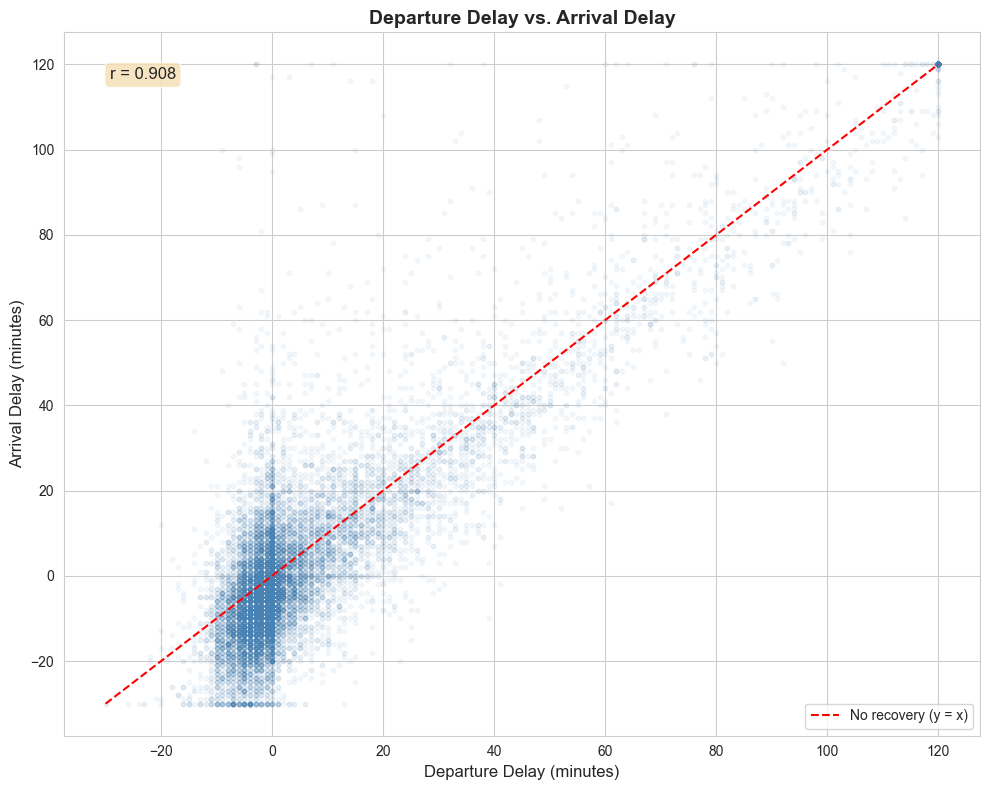

Average time recovered in flight: 2.3 minutes


In [12]:
# Visualization 4: Scatter plot of departure delay vs arrival delay
# Sample to avoid overplotting
sample = df[df['DepDelay'].notna() & df['ArrDelay'].notna()].sample(15000, random_state=42)

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(sample['DepDelay'].clip(-30, 120),
           sample['ArrDelay'].clip(-30, 120),
           alpha=0.05, s=10, color='steelblue')

# Reference line: y = x (no recovery)
ax.plot([-30, 120], [-30, 120], 'r--', linewidth=1.5,
        label='No recovery (y = x)')

# Compute and display correlation
corr = df[['DepDelay', 'ArrDelay']].dropna().corr().iloc[0, 1]
ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes,
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.set_title('Departure Delay vs. Arrival Delay', fontsize=14, fontweight='bold')
ax.set_xlabel('Departure Delay (minutes)')
ax.set_ylabel('Arrival Delay (minutes)')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Quantify time recovery
both_valid = df[df['DepDelay'].notna() & df['ArrDelay'].notna()]
recovery = (both_valid['DepDelay'] - both_valid['ArrDelay']).mean()
print(f'Average time recovered in flight: {recovery:.1f} minutes')

**Observation:** There is a very strong positive correlation between departure delay and arrival delay. The bulk of points fall slightly below the y=x line, indicating that airlines typically recover a few minutes of delay during flight. However, large departure delays almost always result in large arrival delays -- recovery has its limits.

### Question 5: How do arrival delay distributions differ across airlines?

**Assumption:** We expect significant variation between carriers. Budget and regional carriers may have worse delay performance than major legacy carriers, but this could also depend on hub locations (weather-prone vs. not) and operational strategies.

**Approach:** Box plots ordered by median delay are ideal for comparing distributions across many categories. We'll suppress outlier markers (since with 2M rows there would be too many), set reasonable axis limits, and add reference lines for 0 and 15 minutes.

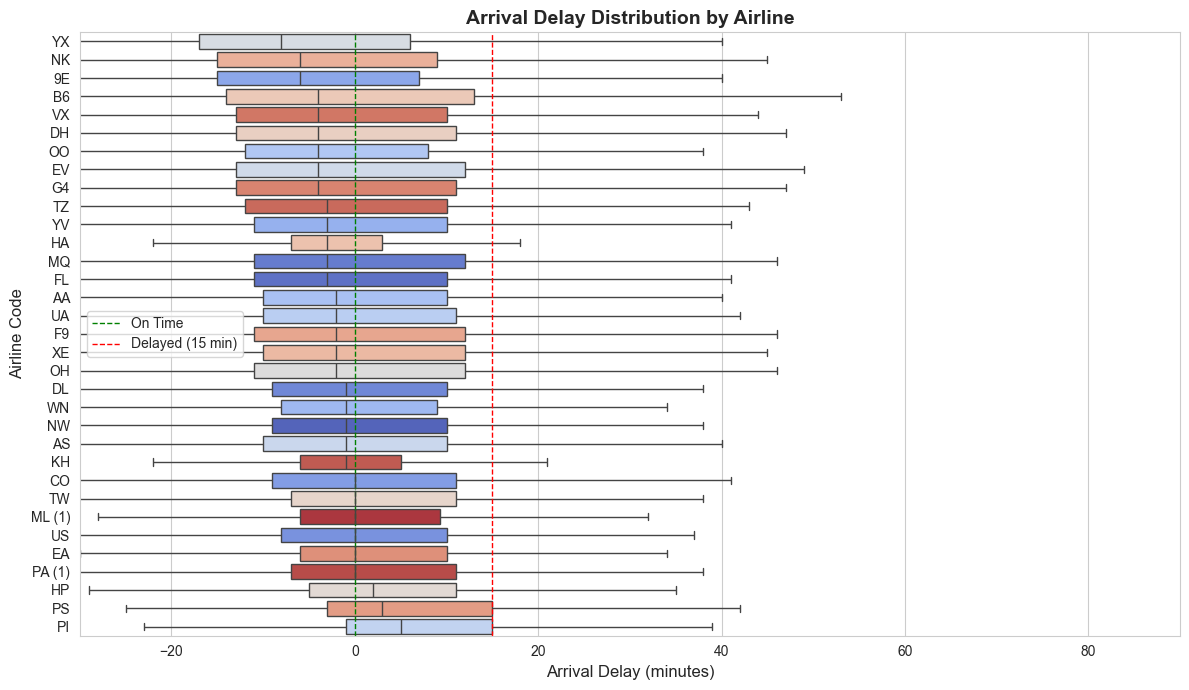

In [13]:
# Visualization 5: Box plot of arrival delay by airline
# Order by median delay
median_order = (df.groupby('Reporting_Airline')['ArrDelay']
                .median().sort_values().index.tolist())

fig, ax = plt.subplots(figsize=(12, 7))
sns.boxplot(y='Reporting_Airline', x='ArrDelay', data=df,
            order=median_order, hue='Reporting_Airline',
            palette='coolwarm', legend=False, fliersize=0, ax=ax)
ax.set_xlim(-30, 90)
ax.axvline(0, color='green', linestyle='--', linewidth=1, label='On Time')
ax.axvline(15, color='red', linestyle='--', linewidth=1, label='Delayed (15 min)')
ax.set_title('Arrival Delay Distribution by Airline', fontsize=14, fontweight='bold')
ax.set_xlabel('Arrival Delay (minutes)')
ax.set_ylabel('Airline Code')
ax.legend()
plt.tight_layout()
plt.show()

**Observation:** Most airlines have median arrival delays near or below zero (on time or early), but the interquartile ranges vary substantially. Some carriers have wider IQR spreads, indicating less consistent performance. The 75th percentile for the worst-performing airlines crosses the 15-minute delay threshold, meaning more than 25% of their flights are officially delayed.

### Question 6: When during the week and day are delays worst?

**Assumption:** We expect delays to worsen later in the day as cascading disruptions accumulate. Friday and Sunday evenings may be worst due to peak travel. Early morning flights should be the most reliable since aircraft start fresh.

**Approach:** A heatmap with DayOfWeek on the y-axis and departure hour on the x-axis, colored by mean arrival delay, provides a compact view of this two-dimensional temporal pattern. Annotated cell values make exact comparisons easy.

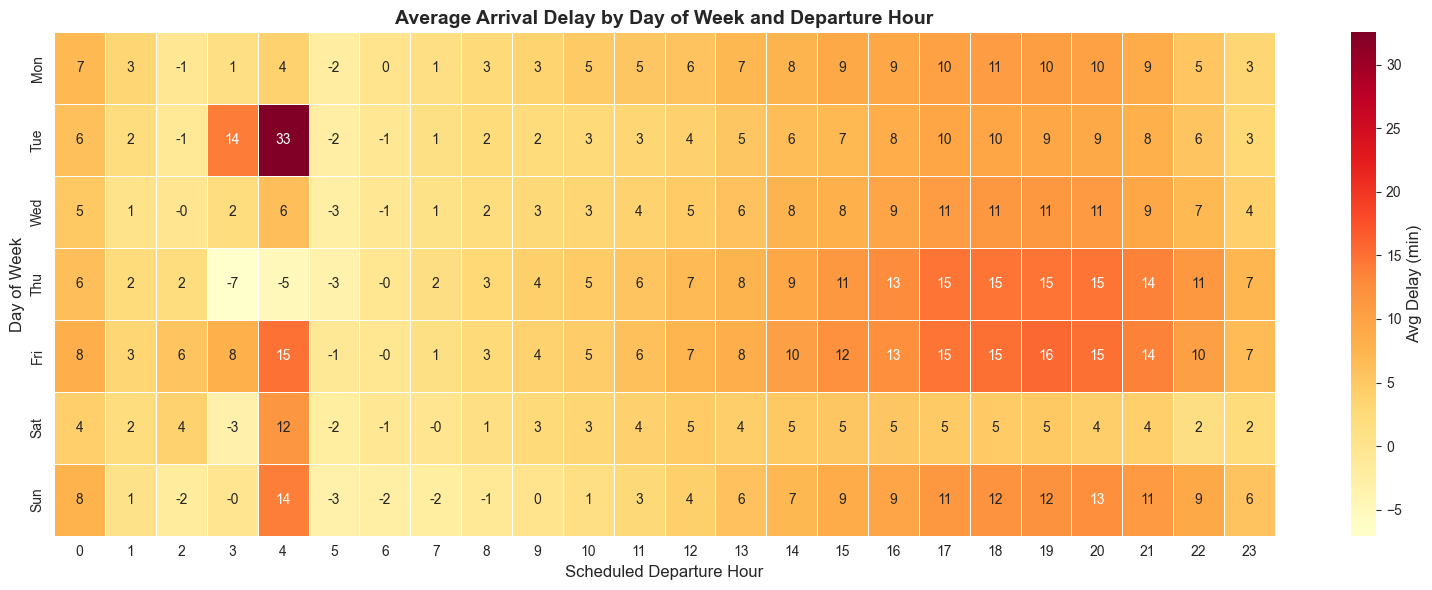

In [14]:
# Visualization 6: Heatmap of average arrival delay by day of week and hour
pivot = (df.groupby(['DayName', 'DepHour'], observed=True)['ArrDelay']
         .mean().reset_index()
         .pivot(index='DayName', columns='DepHour', values='ArrDelay'))

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='.0f',
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Avg Delay (min)'})
ax.set_title('Average Arrival Delay by Day of Week and Departure Hour',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Scheduled Departure Hour')
ax.set_ylabel('Day of Week')
plt.tight_layout()
plt.show()

**Observation:** Delays build throughout the day, with the worst delays occurring in late afternoon and evening hours (16:00-21:00). Early morning flights (05:00-08:00) have the lowest average delays. This pattern is consistent across all days of the week, though Fridays and Sundays tend to show slightly elevated delays compared to midweek days, likely due to business and leisure travel peaks. One anomaly is a relatively high average delay for the 4 AM Tuesday slot, likely due to a small number of flights at that hour making the average sensitive to outliers.

### Dead-End Investigation: Does flight distance predict cancellation rates?

**Assumption:** Shorter regional flights might have higher cancellation rates because they use smaller aircraft that are more susceptible to weather and because the airline loses less revenue by cancelling a short flight.

**Approach:** Let's compute cancellation rate by distance group and see if there's a clear pattern.

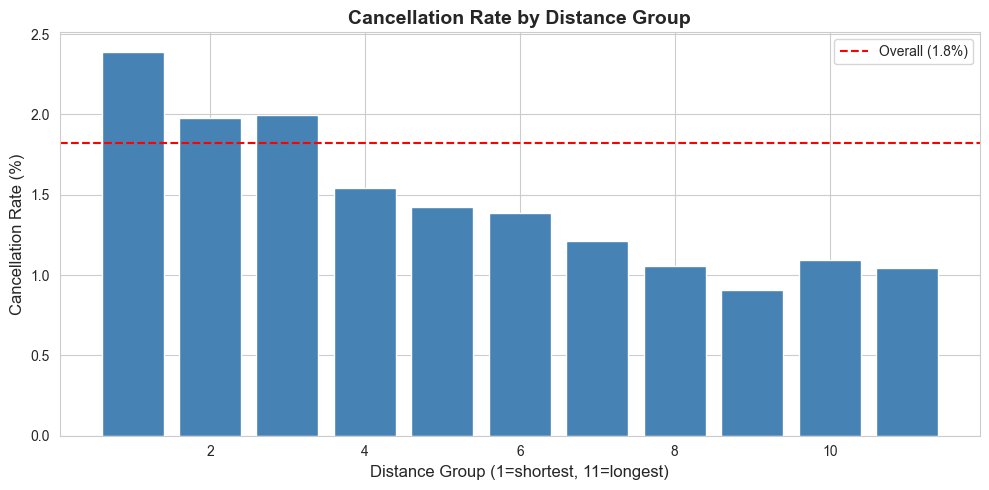

Correlation between distance group and cancellation: -0.027


In [15]:
# Dead-end investigation: Cancellation rate by distance group
cancel_by_dist = (df.groupby('DistanceGroup')['Cancelled']
                  .agg(['mean', 'size']).reset_index())
cancel_by_dist.columns = ['DistanceGroup', 'CancelRate', 'FlightCount']
cancel_by_dist['CancelRate'] *= 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(cancel_by_dist['DistanceGroup'], cancel_by_dist['CancelRate'],
       color='steelblue', edgecolor='white')
ax.set_title('Cancellation Rate by Distance Group', fontsize=14, fontweight='bold')
ax.set_xlabel('Distance Group (1=shortest, 11=longest)')
ax.set_ylabel('Cancellation Rate (%)')
ax.axhline(df['Cancelled'].mean() * 100, color='red', linestyle='--',
           label=f'Overall ({df["Cancelled"].mean()*100:.1f}%)')
ax.legend()
plt.tight_layout()
plt.show()

print(f'Correlation between distance group and cancellation: '
      f'{df["DistanceGroup"].corr(df["Cancelled"]):.3f}')

**Observation (Dead End):** The cancellation rate shows only a very weak relationship with distance group. While there is a slight tendency for shorter flights to have marginally higher cancellation rates, the correlation is negligible. Cancellations appear to be driven primarily by weather events and operational disruptions rather than by route length. This investigation didn't yield a strong enough finding to pursue further or include in the explanatory analysis, but it was worth checking our assumption. We'll focus on delay minutes rather than cancellations for the rest of the analysis.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

Arrival delay shows a very strong positive correlation with departure delay (r > 0.9), confirming that late departures almost always lead to late arrivals. Airlines recover a few minutes on average during flight, but cannot fully compensate for large departure delays.

Delay patterns vary clearly by airline, with some carriers showing much wider delay distributions than others. Delays also have a strong temporal pattern: they accumulate throughout the day (worst in late afternoon/evening) and peak during summer and holiday months.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

The heatmap revealed an interesting interaction between time of day and day of week. The "cascade effect" of delays building throughout the day is remarkably consistent across all seven days, suggesting it is driven by operational factors (aircraft utilization, airport congestion) rather than passenger demand patterns alone.

I also investigated whether flight distance predicts cancellation rates (a potential dead-end exploration). The relationship turned out to be negligible -- cancellations are driven by weather and operational factors rather than route length. This reinforced the decision to focus on delay minutes rather than cancellations as the primary metric.

## Multivariate Exploration

### Question 7: How do the different types of delay causes distribute across months?

**Assumption:** Weather delays should peak in summer (thunderstorms) and winter (snow/ice). NAS delays may follow a similar pattern since weather disrupts airspace. Carrier and late aircraft delays should be more uniform across the year, possibly elevated during peak travel periods.

**Approach:** A FacetGrid with one panel per delay cause type, showing average delay minutes by month as bar charts, allows direct visual comparison of seasonal patterns across all five causes. Using `sharey=False` lets each facet use its own scale since security delays are much smaller than others.

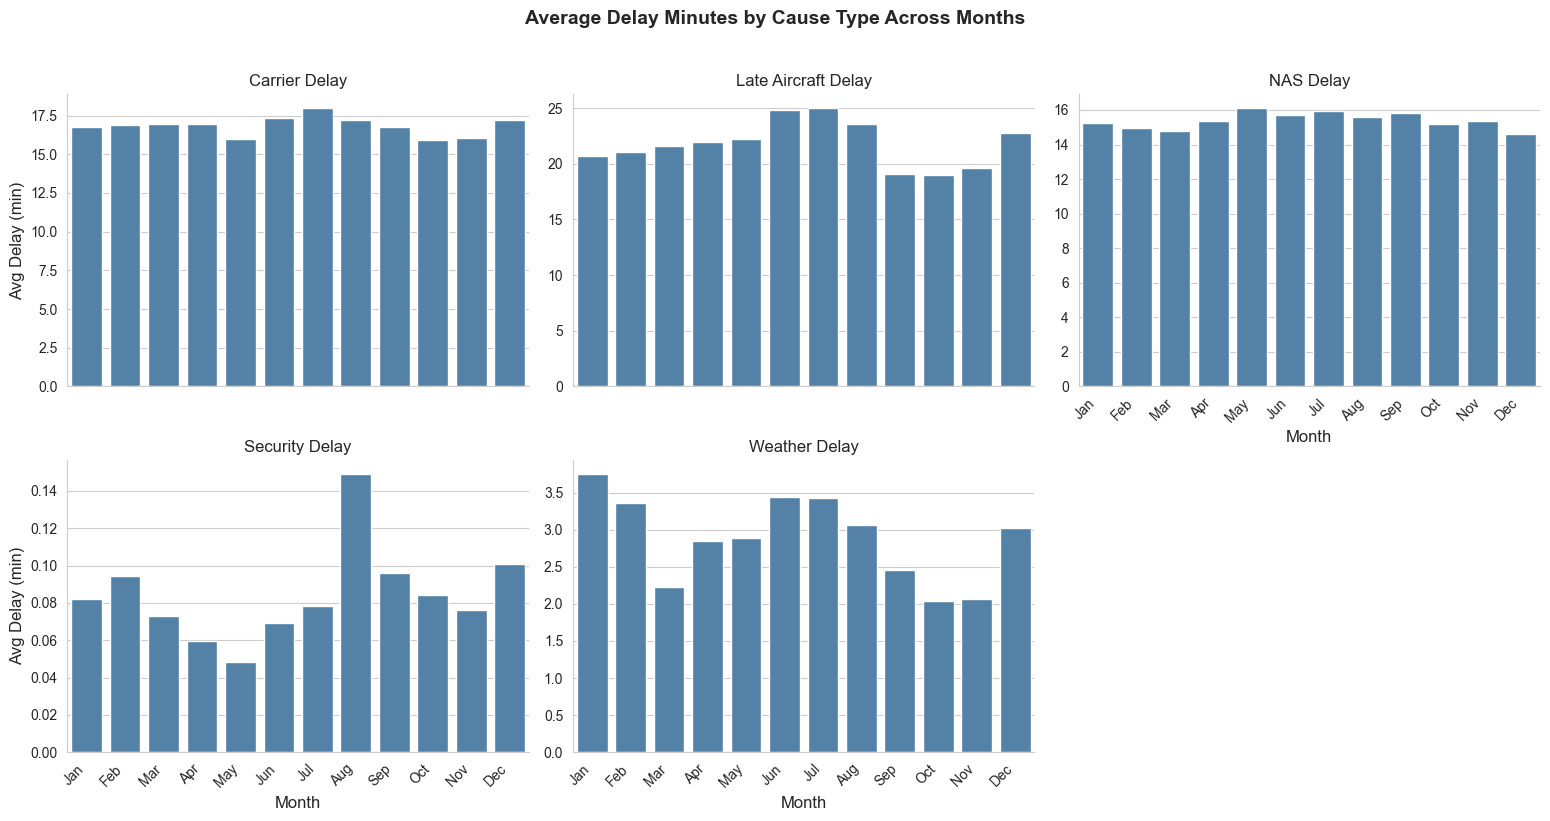

In [16]:
# Visualization 7: Facet plot of delay cause distributions by cause type
# Prepare long-format data for delayed flights only
delay_cause_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay',
                    'SecurityDelay', 'LateAircraftDelay']
cause_names = ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft']

delayed_flights = df[df[delay_cause_cols].notna().all(axis=1)].copy()
delay_melted = delayed_flights[delay_cause_cols + ['MonthName']].melt(
    id_vars='MonthName', var_name='Cause', value_name='DelayMinutes'
)
delay_melted['Cause'] = delay_melted['Cause'].map(dict(zip(delay_cause_cols, cause_names)))

# Compute average delay by cause and month
avg_by_cause_month = (delay_melted.groupby(['MonthName', 'Cause'], observed=True)['DelayMinutes']
                      .mean().reset_index())

g = sns.FacetGrid(avg_by_cause_month, col='Cause', col_wrap=3,
                  sharey=False, height=4, aspect=1.3)
g.map_dataframe(sns.barplot, x='MonthName', y='DelayMinutes',
                color='steelblue', edgecolor='white')
g.set_titles('{col_name} Delay')
g.set_axis_labels('Month', 'Avg Delay (min)')

# Rotate x-axis labels using tick_params and explicit label setting
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)
    for label in ax.get_xticklabels():
        label.set_ha('right')

g.figure.suptitle('Average Delay Minutes by Cause Type Across Months',
                  fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

**Observation:** Different delay causes show distinct seasonal patterns. Weather delays spike during winter and summer months when storms are more frequent. NAS (National Airspace System) delays show similar seasonal variation, as weather disruptions cause airspace congestion. Carrier and late aircraft delays are more evenly distributed but still elevated during peak travel periods. Security delays are minimal throughout the year.

### Question 8: How does the relationship between route distance and delay vary by airline?

**Assumption:** Longer routes might show lower average delays since airlines can make up more time on longer flights. Alternatively, longer routes might connect busier hub airports. We expect different carriers to show distinct patterns based on their network structures.

**Approach:** A scatter plot with three encodings -- x=distance, y=mean delay, color=airline, size=flight count -- aggregated at the route level for the top 5 carriers. Routes with fewer than 50 flights are excluded for statistical reliability. This reveals whether distance predicts delays and how carriers differ.

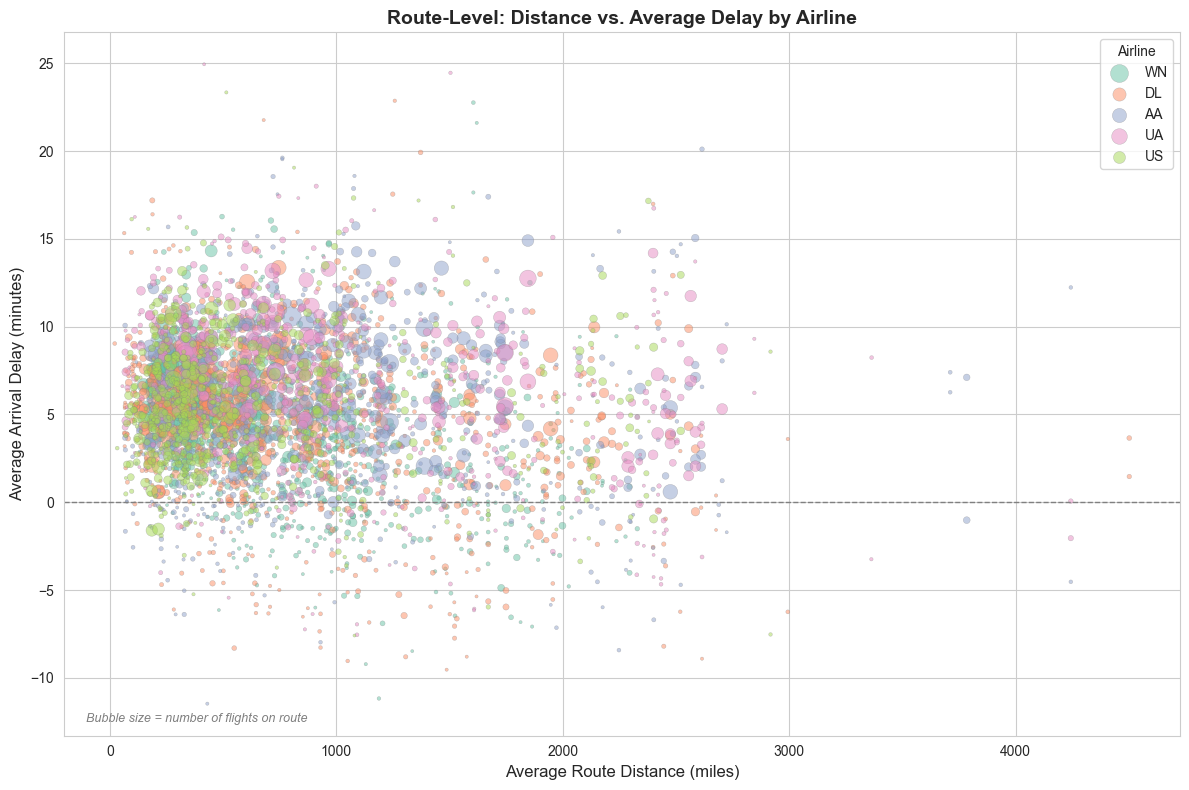

In [17]:
# Visualization 8: Scatter plot with multiple encodings
# Aggregate by route and airline for top 5 carriers
top5 = df['Reporting_Airline'].value_counts().head(5).index.tolist()
route_stats = (df[df['Reporting_Airline'].isin(top5)]
               .groupby(['Reporting_Airline', 'Origin', 'Dest'])
               .agg(mean_delay=('ArrDelay', 'mean'),
                    flight_count=('ArrDelay', 'size'),
                    mean_distance=('Distance', 'mean'))
               .reset_index())

# Filter to routes with at least 50 flights for reliability
route_stats = route_stats[route_stats['flight_count'] >= 50]

fig, ax = plt.subplots(figsize=(12, 8))
palette = sns.color_palette('Set2', n_colors=5)

for i, airline in enumerate(top5):
    subset = route_stats[route_stats['Reporting_Airline'] == airline]
    ax.scatter(subset['mean_distance'], subset['mean_delay'],
              s=subset['flight_count'] / 10,
              alpha=0.5, label=airline, color=palette[i], edgecolor='gray',
              linewidth=0.3)

ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Route-Level: Distance vs. Average Delay by Airline',
             fontsize=14, fontweight='bold')
ax.set_xlabel('Average Route Distance (miles)')
ax.set_ylabel('Average Arrival Delay (minutes)')
ax.legend(title='Airline', loc='upper right')

# Add annotation for bubble size
ax.text(0.02, 0.02, 'Bubble size = number of flights on route',
        transform=ax.transAxes, fontsize=9, fontstyle='italic', color='gray')

plt.tight_layout()
plt.show()

**Observation:** There is no strong relationship between route distance and average delay. Short- and long-haul routes show similar delay variability. However, the highest-volume routes (largest bubbles) tend to have average delays closer to zero, likely because high-frequency routes on major corridors are better optimized. Different airlines show distinct clustering patterns, with some carriers having more routes with positive average delays than others.

### Question 9: How do the five delay cause types relate to each other?

**Assumption:** We might expect delay causes to co-occur -- a weather event might cause both weather delays and NAS delays. Alternatively, for any given flight, one cause might dominate while others are zero, suggesting they are more independent than expected.

**Approach:** A pair plot (plot matrix) of the four main delay causes (excluding SecurityDelay which is nearly always zero) will reveal pairwise relationships. We sample 5,000 delayed flights with low alpha to avoid overplotting, and print the correlation matrix for quantitative comparison.

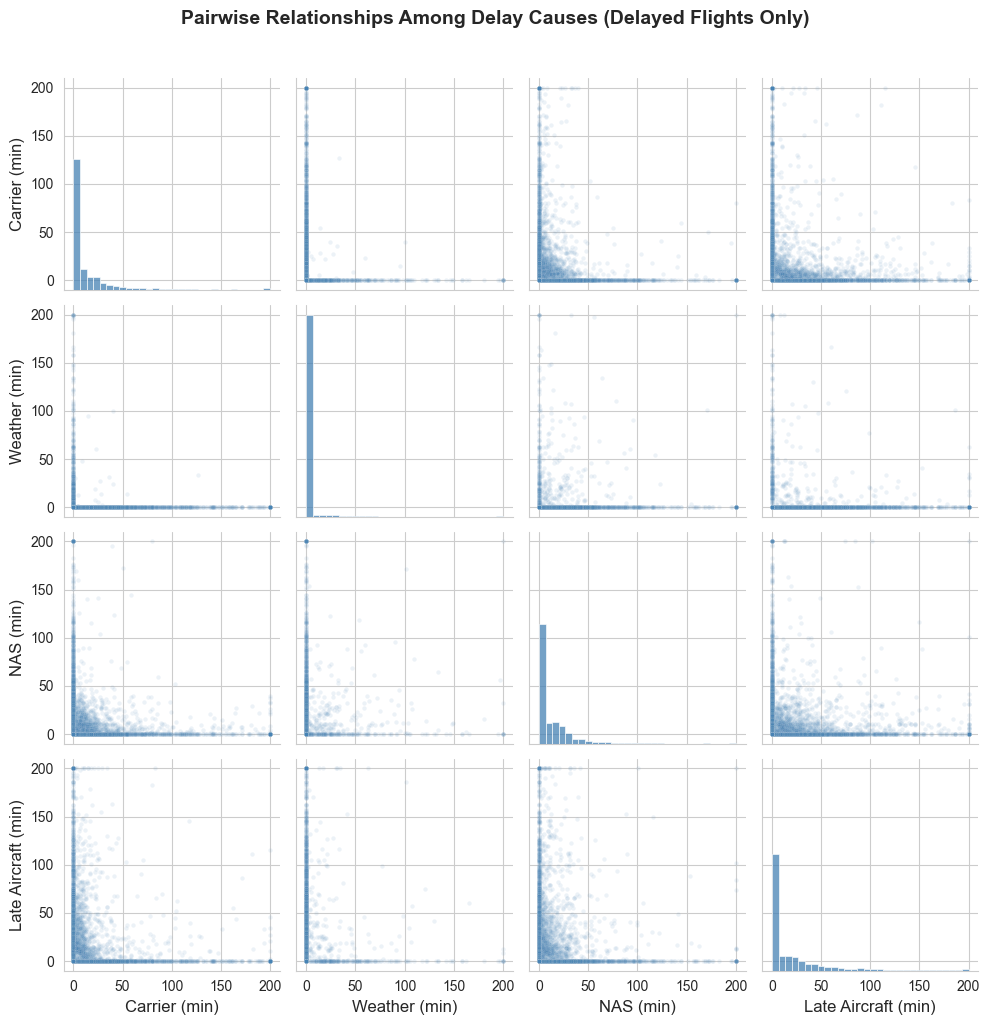

Correlation matrix of delay causes:
                   CarrierDelay  WeatherDelay  NASDelay  LateAircraftDelay
CarrierDelay              1.000        -0.047    -0.123             -0.104
WeatherDelay             -0.047         1.000    -0.012             -0.028
NASDelay                 -0.123        -0.012     1.000             -0.145
LateAircraftDelay        -0.104        -0.028    -0.145              1.000


In [18]:
# Visualization 9: Pair plot of delay causes
# Sample delayed flights and drop SecurityDelay (nearly always 0)
pair_cols = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay']
pair_labels = {'CarrierDelay': 'Carrier (min)', 'WeatherDelay': 'Weather (min)',
               'NASDelay': 'NAS (min)', 'LateAircraftDelay': 'Late Aircraft (min)'}
pair_data = (delayed_flights[pair_cols]
             .sample(min(5000, len(delayed_flights)), random_state=42)
             .rename(columns=pair_labels))

# Clip to reasonable range for readability
pair_data = pair_data.clip(0, 200)

g = sns.pairplot(pair_data, diag_kind='hist',
                 plot_kws={'alpha': 0.1, 's': 10, 'color': 'steelblue'},
                 diag_kws={'bins': 30, 'color': 'steelblue', 'edgecolor': 'white'})
g.figure.suptitle('Pairwise Relationships Among Delay Causes (Delayed Flights Only)',
                  fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Correlation matrix
print('Correlation matrix of delay causes:')
print(delayed_flights[pair_cols].corr().round(3))

**Observation:** Most delay cause pairs show weak correlations. A notable pattern is that for any given delayed flight, typically one cause dominates while others are zero or near-zero. The diagonal histograms show that all delay causes are heavily right-skewed with most values near zero. Weather and NAS delays show a modest positive correlation, which makes sense because severe weather disrupts the national airspace system, causing both types of delay simultaneously. Late aircraft delays are somewhat independent, reflecting cascading schedule disruptions from earlier flights.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

The multivariate exploration revealed several reinforcing patterns:
- **Seasonal and cause-specific patterns align:** Weather delays peak exactly when overall delay rates are highest (summer, winter), confirming weather as a key driver of seasonal delay variation.
- **Late aircraft delays are pervasive:** They appear in large amounts across all months, supporting the idea that cascading schedule disruptions are a systemic issue in hub-and-spoke airline operations.
- **Route distance does not predict delays well,** but airline identity does -- different carriers show distinctly different delay profiles even on similar-length routes.

### Were there any interesting or surprising interactions between features?

The most surprising finding was the relative independence of delay causes. For a given delayed flight, one cause typically dominates rather than multiple causes compounding. The exception is the weather-NAS correlation, where severe weather disrupts both individual flights and the broader airspace system simultaneously. Security delays were negligible throughout the analysis.

## Conclusions

### Summary of Findings

1. **Most flights are on time:** The majority of flights arrive on time or slightly early. The arrival delay distribution is heavily right-skewed, with about 80% of flights arriving within 15 minutes of schedule.

2. **Delays cascade but airlines recover partially:** Departure delays are very strongly correlated with arrival delays (r > 0.9), but airlines recover an average of several minutes during flight. However, this recovery is insufficient for large delays.

3. **Time of day is the strongest predictor:** Delays build throughout the day, with the worst performance in late afternoon and evening (16:00-21:00). Early morning flights are the most reliable. This pattern holds across all days of the week.

4. **Seasonal patterns are weather-driven:** Summer (thunderstorms) and winter (snow/ice) months show the highest delay rates. Weather delays and NAS delays spike during these periods, while carrier and late aircraft delays are more stable year-round.

5. **Late aircraft delays are the largest systemic cause:** Among delayed flights, late aircraft (cascading schedule disruptions) and carrier-related issues contribute the most delay minutes. Security delays are negligible.

6. **Airline performance varies significantly:** Different carriers show distinctly different delay distributions. The most reliable airlines have narrow IQR and median delays near or below zero.

7. **Route distance is not a major factor:** There is no strong relationship between route distance and delay severity. High-frequency routes tend to perform slightly better on average.

### Reflection

The exploration followed a logical progression from single-variable distributions to pairwise relationships to multivariate interactions. Key decisions included clipping extreme values for histogram readability, sampling for scatter plots to avoid overplotting, and filtering to delayed flights only when analyzing delay causes (since these columns are null for non-delayed flights). The use of ordered categoricals for temporal variables ensured correct ordering in all visualizations.